### Phase 2 - Data Preparation & Transformation (Flipkart Smartphone Dataset)

**Project Objective**  

The purpose of Phase 2 is to prepare the cleaned dataset for business visualization and analysis in Power BI. Instead of running a full-scale EDA, we focused on -

- Evaluate and enhance data quality  
- Handle missing values and duplicates  
- Standardize and normalize feature formats  
- Extract and engineer meaningful variables (RAM, ROM, Display, Battery, etc.)  
- Capping outliers for consistency.
- Structuring the dataset for direct integration with Power BI.  

---

Let’s set the stage by importing the essential libraries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### 1. Data Loading & Initial Overview

Let’s take a first step by loading the CSV file.

In [3]:
df = pd.read_csv('flipkart_smartphones.csv')

Let’s take a quick look at the first few rows of our dataset.

In [4]:
df.head()

,Name,Price,Discount,Rating,Specs
0,"Samsung Galaxy F05 (Twilight Blue, 64 GB)",6249,37% off,4.2,4 GB RAM | 64 GB ROM | Expandable Upto 1 TB; 1...
1,"REDMI A3X (Ocean Green, 128 GB)",6499,40% off,4.1,4 GB RAM | 128 GB ROM | Expandable Upto 1 TB; ...
2,"MOTOROLA g05 (Forest Green, 64 GB)",6999,30% off,4.2,4 GB RAM | 64 GB ROM | Expandable Upto 1 TB; 1...
3,"POCO C71 (Power Black, 128 GB)",6999,30% off,4.1,6 GB RAM | 128 GB ROM | Expandable Upto 2 TB; ...
4,"POCO C71 (Desert Gold, 128 GB)",6999,30% off,4.1,6 GB RAM | 128 GB ROM | Expandable Upto 2 TB; ...


Let’s explore the dataset’s structure.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      984 non-null    object 
 1   Price     984 non-null    int64  
 2   Discount  937 non-null    object 
 3   Rating    968 non-null    float64
 4   Specs     984 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 38.6+ KB


Let’s check for missing values in the dataset.

In [6]:
df.isnull().sum()

Name         0
Price        0
Discount    47
Rating      16
Specs        0
dtype: int64

Let’s see if there are any duplicate rows hiding in the data.

In [7]:
df.duplicated().sum()

np.int64(141)

Let’s Remove Duplicate Records for Data Consistency

In [8]:
df.drop_duplicates(inplace=True)

Let’s Handle Missing Values to Ensure Data Completeness

In [9]:
# 1. Fill missing Price with median
df['Price'] = df['Price'].fillna(df['Price'].median())

# 2. Fill missing Discount with 0 (since it means no discount info given)
df['Discount'] = df['Discount'].fillna(0)

# 3. Fill missing Rating with brand-wise mean, then global mean if still null
df['Rating'] = df.groupby('Name')['Rating'].transform(lambda x: x.fillna(x.mean()))
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())

print("Null values in Price, Discount, and Rating handled successfully.")

Null values in Price, Discount, and Rating handled successfully.


### 2. Feature Extraction & Data Structuring 

Let’s Extract and Standardize Smartphone Brands for Consistency

In [10]:
# Extract first word
df["Brand"] = df["Name"].str.split().str[0].str.title()

# List of valid brands (you can expand this if needed)
valid_brands = [
    "Redmi","Realme","Samsung","Vivo","Poco","Motorola","Oppo","Infinix","Iqoo","Tecno",
    "Oneplus","Itel","Lava","Cmf","Google","Nothing","Apple","Micromax","Nokia",
    "Honor","Lyf","Karbonn","Gionee","Xolo","Panasonic","Hmd"
]

# Clean brands: if not valid, try second word
def clean_brand(name):
    words = name.split()
    if not words:
        return "Unknown"
    first = words[0].title()
    if first in valid_brands:
        return first
    elif len(words) > 1 and words[1].title() in valid_brands:
        return words[1].title()
    else:
        return "Unknown"

df["Brand"] = df["Name"].apply(clean_brand)

- This block separate the brand name from the product title and validates it against a curated list of known smartphone brands.
If the first word is invalid, the logic checks the second word, otherwise assigns “Unknown”.
This ensures brand-level analysis in Power BI is accurate, clean, and free from noisy or inconsistent entries.

Let’s extracting Key Smartphone Features for Structured Analysis

In [11]:
# Create a new column with phone name before the bracket
df['Phone_Model'] = df['Name'].str.split(r'\(').str[0]
df['Phone_Model'] = df['Phone_Model'].str.strip()

# Discount cleanup 
df["Discount"] = (
    df["Discount"]
    .astype(str)                     # convert to string
    .str.replace("% off", "", regex=False)   # remove '% off'
    .str.replace("%", "", regex=False)       # in case only '%' exists
    .str.strip()
)

# Convert Discount to numeric, coercing errors to NaN
df["Discount"] = pd.to_numeric(df["Discount"], errors="coerce")

# Calculate Original Price
df["Original_Price"] = df.apply(
    lambda row: round(row["Price"] / (1 - (row["Discount"] / 100)), 2)
    if pd.notna(row["Price"]) and pd.notna(row["Discount"]) and row["Discount"] > 0
    else row["Price"],
    axis=1)

# RAM (GB)
df["RAM_GB"] = df["Specs"].str.extract(r"(\d+)\s*GB RAM", expand=False).astype(float)

# ROM (GB)
df["ROM_GB"] = df["Specs"].str.extract(r"(\d+)\s*GB ROM", expand=False).astype(float)

# Expandable storage
df["Expandable_Storage"] = (df["Specs"].str.extract(r"Expandable Upto\s*([\d\.]+\s*(?:TB|GB))", expand=False).str.strip())
df["Expandable_TB"] = (df["Expandable_Storage"].str.replace("TB", "", case=False, regex=False).str.replace("GB", "", case=False, regex=False))

# Display size (inches) – inside parentheses
df["Display_Size_inch"] = (df["Specs"].str.extract(r"\(([\d\.]+)\s*inch\)", expand=False)).astype(float)

# Display type (HD, FHD, AMOLED, etc.)
df["Display_Type"] = df["Specs"].str.extract(r"(HD\+|FHD\+|AMOLED|Super AMOLED|OLED|Retina)", expand=False)

# Rear Camera
df["RearCam"] = df["Specs"].str.extract(r"(\d+MP[^\|]*)(?=\s*\|)", expand=False).str.strip()

# Front Camera
df["FrontCam"] = df["Specs"].str.extract(r"(\d+MP)\s*Front Camera", expand=False)

# Battery (mAh)
df["Battery_mAh"] = (df["Specs"].str.extract(r"(\d+)\s*mAh", expand=False)).astype(float)

# Processor (catch text ending with 'Processor')
df["Processor"] = df["Specs"].str.extract(r"([A-Za-z0-9\s\+\-]+Processor)", expand=False)

# Warranty
df["Warranty_Years"] = (df["Specs"].str.extract(r"(\d+)\s*Year", expand=False)).astype(float)

- This code block extracts and organizes key smartphone attributes such as RAM, ROM, display size, display type, cameras, battery, and processor. By transforming raw, unstructured text into clean numeric and categorical columns, it prepares the dataset for reliable comparisons, trend analysis, and professional visualizations in tools like Power BI.

Let’s Organize Columns for a Clean, Business-Ready Dataset

In [12]:
# Define the ideal column order for structured output
ideal_order = [
    "Brand",
    "Phone_Model",
    "Name",
    "Price",
    "Original_Price",
    "Discount",
    "Rating",
    "RAM_GB",
    "ROM_GB",
    "Display_Size_inch",
    "Display_Type",
    "RearCam",
    "FrontCam",
    "Battery_mAh",
    "Processor",
    "Warranty_Years",
    "Specs"
]

# Reorder dataframe columns while ignoring any missing ones
df = df[[col for col in ideal_order if col in df.columns]]

# Save the organized dataset
output_file = "flipkart_smartphones_organized.csv"
df.to_csv(output_file, index=False)

print(f"Columns reordered & saved as '{output_file}'")


Columns reordered & saved as 'flipkart_smartphones_organized.csv'


- This block rearranges the dataset into an ideal column order for better readability and structured analysis.
It then saves the final version as a clean CSV file, ensuring the dataset is well-organized, consistent, and ready for Power BI integration.

### 3. Data Cleaning & Preprocessing

Let’s Reload the Final Organized Dataset

In [13]:
new_df = pd.read_csv("flipkart_smartphones_organized.csv")

Let’s Inspect the Dataset Structure and Data Types

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              843 non-null    object 
 1   Phone_Model        843 non-null    object 
 2   Name               843 non-null    object 
 3   Price              843 non-null    int64  
 4   Original_Price     843 non-null    float64
 5   Discount           843 non-null    int64  
 6   Rating             843 non-null    float64
 7   RAM_GB             823 non-null    float64
 8   ROM_GB             832 non-null    float64
 9   Display_Size_inch  831 non-null    float64
 10  Display_Type       486 non-null    object 
 11  RearCam            678 non-null    object 
 12  FrontCam           658 non-null    object 
 13  Battery_mAh        831 non-null    float64
 14  Processor          687 non-null    object 
 15  Warranty_Years     760 non-null    float64
 16  Specs              843 non

Let’s Rechecking for missing values in the dataset again.

In [15]:
new_df.isnull().sum()

Brand                  0
Phone_Model            0
Name                   0
Price                  0
Original_Price         0
Discount               0
Rating                 0
RAM_GB                20
ROM_GB                11
Display_Size_inch     12
Display_Type         357
RearCam              165
FrontCam             185
Battery_mAh           12
Processor            156
Warranty_Years        83
Specs                  0
dtype: int64

Let's Impute Missing Data for RAM, ROM, Display, Camera, Battery, and Processor

In [23]:
# 1. RAM_GB - usually standard sizes (4, 6, 8, 12, etc.)
df['RAM_GB'] = df.groupby('Brand')['RAM_GB'].transform(lambda x: x.fillna(x.median()))
df['RAM_GB'] = df['RAM_GB'].fillna(df['RAM_GB'].median())  # fallback

# 2. ROM_GB - similar (32, 64, 128, 256, etc.)
df['ROM_GB'] = df.groupby('Brand')['ROM_GB'].transform(lambda x: x.fillna(x.median()))
df['ROM_GB'] = df['ROM_GB'].fillna(df['ROM_GB'].median())

# 3. Display_Size_inch - continuous numeric (5.5–6.8 range)
df['Display_Size_inch'] = df.groupby('Brand')['Display_Size_inch'].transform(lambda x: x.fillna(x.mean()) if x.notna().any() else x)
df['Display_Size_inch'] = df['Display_Size_inch'].fillna(df['Display_Size_inch'].mean())

# 4. Display_Type - categorical (HD+, FHD+, AMOLED, Super AMOLED, etc.)
df['Display_Type'] = df['Display_Type'].fillna(df['Display_Type'].mode()[0])

# 5. Camera - string (Rear + Front megapixels)
df['RearCam'] = df['RearCam'].fillna('Not Specified')
df['FrontCam'] = df['FrontCam'].fillna('Not Specified')

# 6. Battery_mAh - numeric (common values: 4000, 5000, 6000)
df['Battery_mAh'] = df.groupby('Brand')['Battery_mAh'].transform(lambda x: x.fillna(x.median()) if x.notna().any() else x)
df['Battery_mAh'] = df['Battery_mAh'].fillna(df['Battery_mAh'].median())

# 7. Processor - text (Helio, Snapdragon, Dimensity, etc.)
df['Processor'] = df['Processor'].fillna('Not Specified')

# 8. Warranty_Years - numeric (1, 2, etc.)
df['Warranty_Years'] = df['Warranty_Years'].fillna(1)  


c:\Users\HETVI\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\HETVI\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\HETVI\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


- This block filled missing values with brand-wise median/mean (with global fallback) for RAM, ROM, Display Size, Battery.
Categorical fields (Display Type, Camera, Processor) were filled with mode or default labels.

In [24]:
df.isnull().sum()

Brand                0
Phone_Model          0
Name                 0
Price                0
Original_Price       0
Discount             0
Rating               0
RAM_GB               0
ROM_GB               0
Display_Size_inch    0
Display_Type         0
RearCam              0
FrontCam             0
Battery_mAh          0
Processor            0
Warranty_Years       0
Specs                0
dtype: int64

Let's View the Statistical Summary of Numeric Columns

In [25]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
Price,843.0,20661.128114,16033.677143,745.00,10096.00,15999.00,25999.00,124999.00
Original_Price,843.0,25682.504828,18996.483952,1482.14,13854.22,20767.69,32907.67,164382.19
Discount,843.0,20.729537,10.548290,0.00,13.00,20.00,28.00,55.00
Rating,843.0,4.306763,0.189893,2.30,4.20,4.30,4.40,4.90
RAM_GB,843.0,7.223013,2.889097,1.00,4.00,8.00,8.00,16.00
ROM_GB,843.0,172.631079,100.830755,8.00,128.00,128.00,256.00,512.00
Display_Size_inch,843.0,6.627081,0.490595,1.77,6.67,6.70,6.77,7.60
Battery_mAh,843.0,5462.080664,877.247901,800.00,5000.00,5160.00,6000.00,7550.00
Warranty_Years,843.0,1.001186,0.034442,1.00,1.00,1.00,1.00,2.00


Let's View the Summary of categoriacl Columns

In [26]:
df.describe(include='object').T 

,count,unique,top,freq
Brand,843,24,Realme,129
Phone_Model,843,285,Nothing Phone,13
Name,843,704,"IQOO Z10X 5G (Titanium, 128 GB)",4
Display_Type,843,3,HD+,828
RearCam,843,82,Not Specified,165
FrontCam,843,15,Not Specified,185
Processor,843,151,Not Specified,156
Specs,843,469,6 GB RAM | 128 GB ROM | Expandable Upto 1 TB; ...,8


Let's Identify Outliers in All Numeric Features Using the IQR Method

In [27]:
num_col = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers")

Price: 41 outliers
Original_Price: 35 outliers
Discount: 6 outliers
Rating: 13 outliers
RAM_GB: 16 outliers
ROM_GB: 36 outliers
Display_Size_inch: 91 outliers
Battery_mAh: 25 outliers
Warranty_Years: 1 outliers


Let's Cap Outliers in Numeric Columns Using the IQR Method

Price: 41 outliers capped


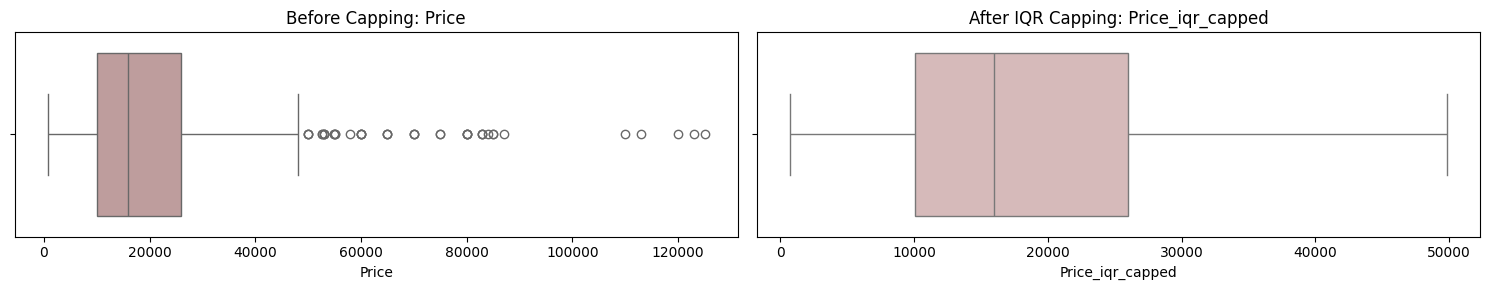

Original_Price: 35 outliers capped


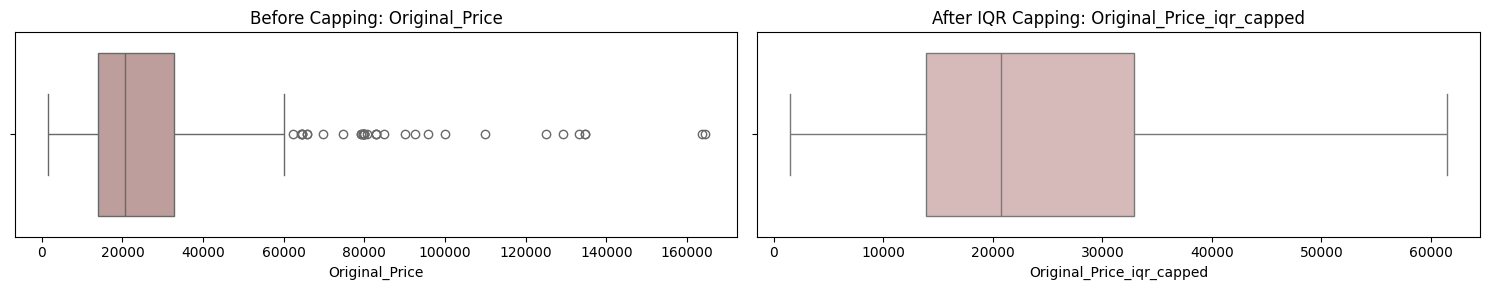

Discount: 6 outliers capped


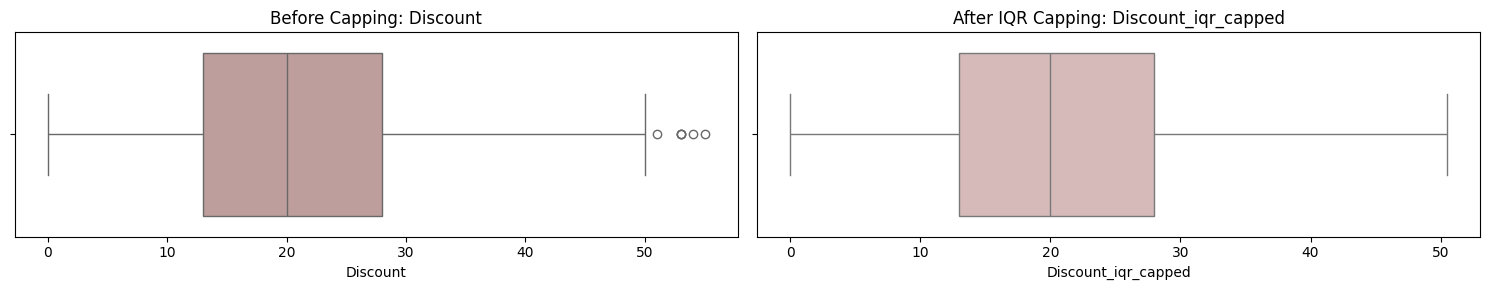

Rating: 13 outliers capped


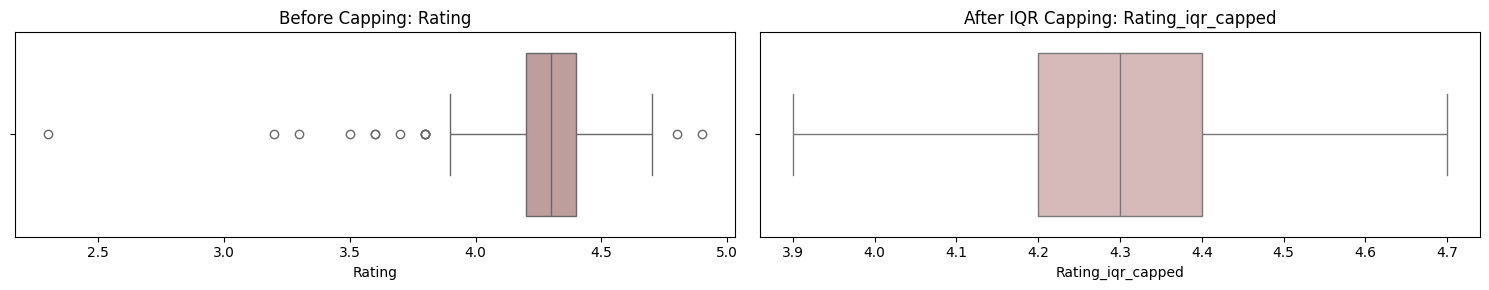

RAM_GB: 16 outliers capped


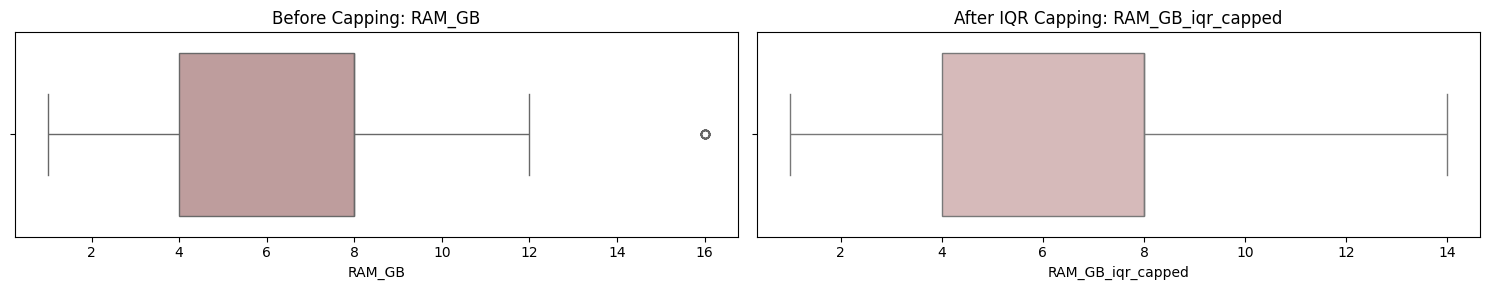

ROM_GB: 36 outliers capped


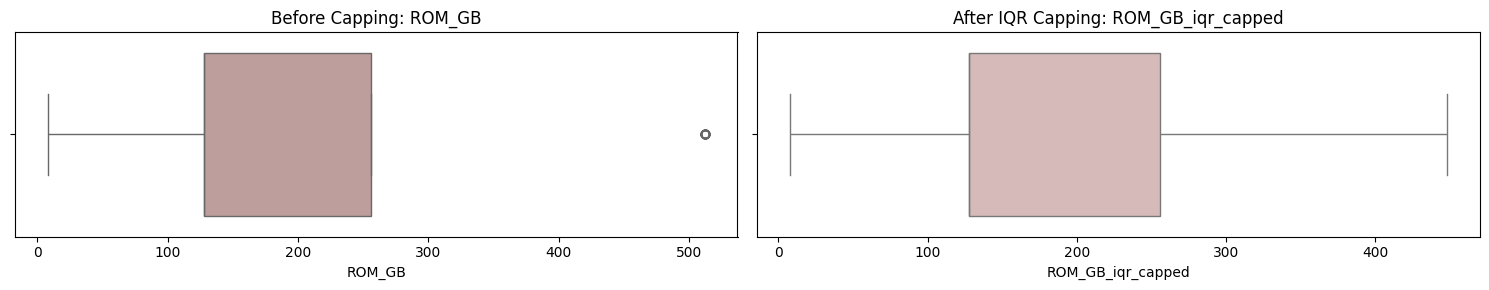

Display_Size_inch: 91 outliers capped


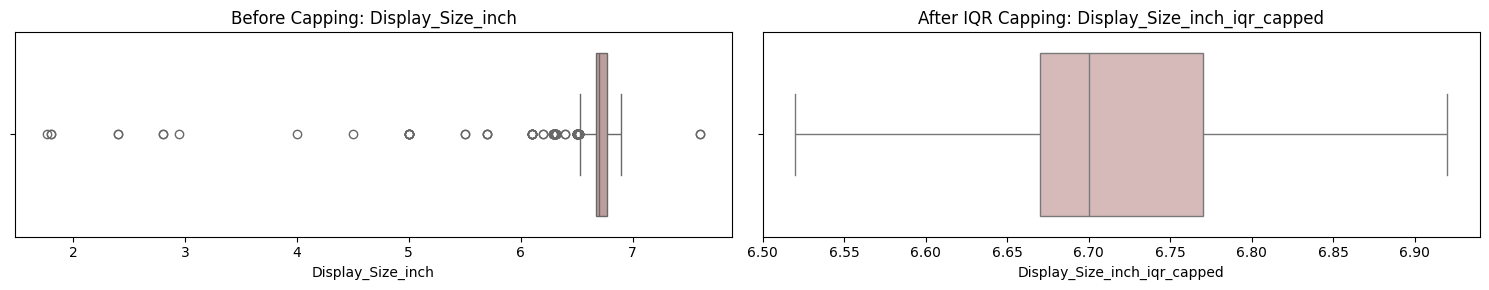

Battery_mAh: 25 outliers capped


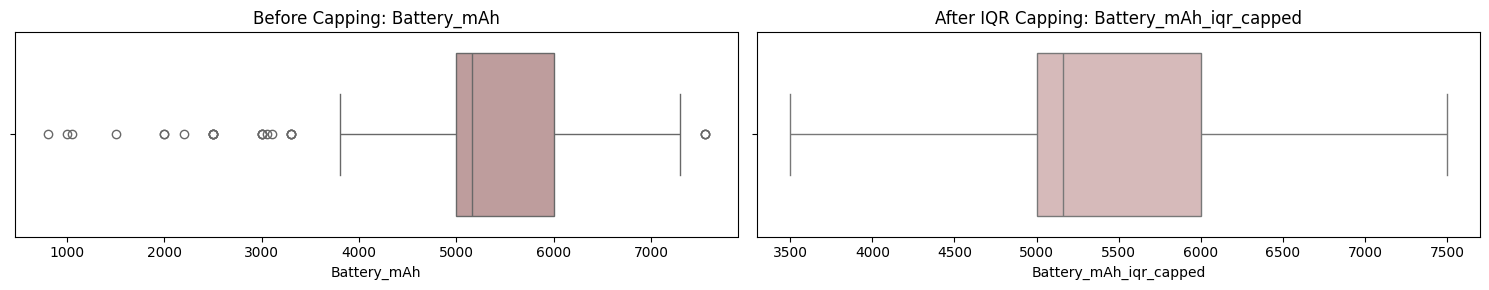

Warranty_Years: 1 outliers capped


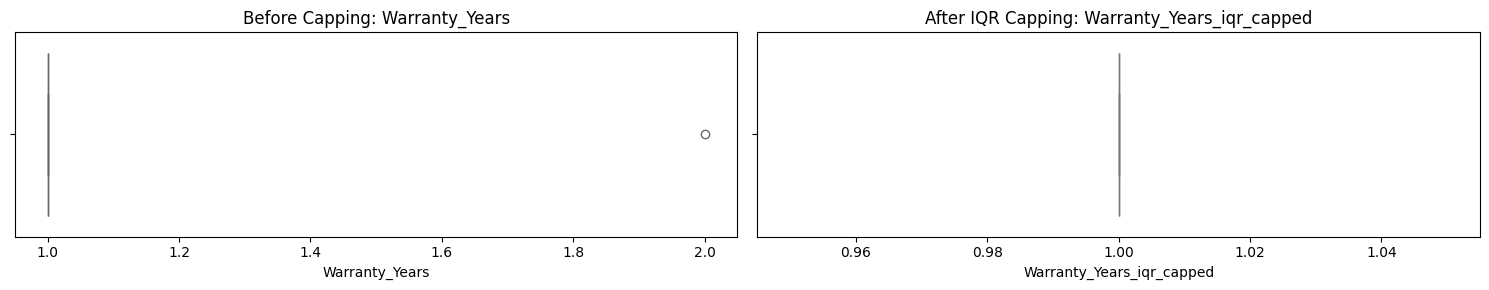

In [28]:
for col in num_col:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers capped")

    # Create capped version
    capped_col = f"{col}_iqr_capped"
    df[capped_col] = df[col].clip(lower=lower, upper=upper)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    sns.boxplot(x=df[col], ax=axes[0], color='#C39898')
    axes[0].set_title(f"Before Capping: {col}")
    sns.boxplot(x=df[capped_col], ax=axes[1], color='#DBB5B5')
    axes[1].set_title(f"After IQR Capping: {capped_col}")
    plt.tight_layout()
    plt.show()
    
    df[col] = df[capped_col]
    df.drop(columns=[capped_col], inplace=True)

- Identified outliers in numeric columns using the IQR method.
- Capped outliers to lower and upper IQR bounds to reduce their impact.
- Visualized before and after capping with boxplots for better understanding.

Let's save the cleaned dataset for visualization.

In [29]:
df.to_csv("flipkart_smartphones_cleaned.csv", index=False)

---

### Phase 3 Conclusion & Next Steps  

In this phase, we successfully:  
- Cleaned and standardized the Flipkart Smartphone dataset.  
- Handled missing values, duplicates, and feature inconsistencies.  
- Engineered key attributes such as RAM, ROM, Display, and Battery.  
- Capped outliers to stabilize extreme variations without removing valuable signals.  
- Structured the dataset for smooth integration into Power BI.  
 

---

### Next Steps (Phase 4 – Visualization & Insights)
 
The cleaned dataset will be imported into Power BI to:  
- Track real-time pricing and discount trends.  
- Identify smartphone segments with aggressive discount strategies.  
- Compare product pricing against specifications (RAM, Battery, Storage, etc.).  
- Deliver actionable insights for competitive positioning and market strategy. 

---
---